In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    DATOS_DIR   = './' # carpeta donde se encuentran los datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Leer set de datos
df = pd.read_csv(DATOS_DIR+'weather_dataset_preprocesado.csv')
df

,datetime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,2014-09-24 12:00:00,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
50220,2014-09-24 13:00:00,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
50221,2014-09-24 14:00:00,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5
50222,2014-09-24 15:00:00,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,2.86,4.32,172.0


In [4]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df['T (degC)'])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (40179,)
Tamaño set de validación: (5022,)
Tamaño set de prueba: (5023,)


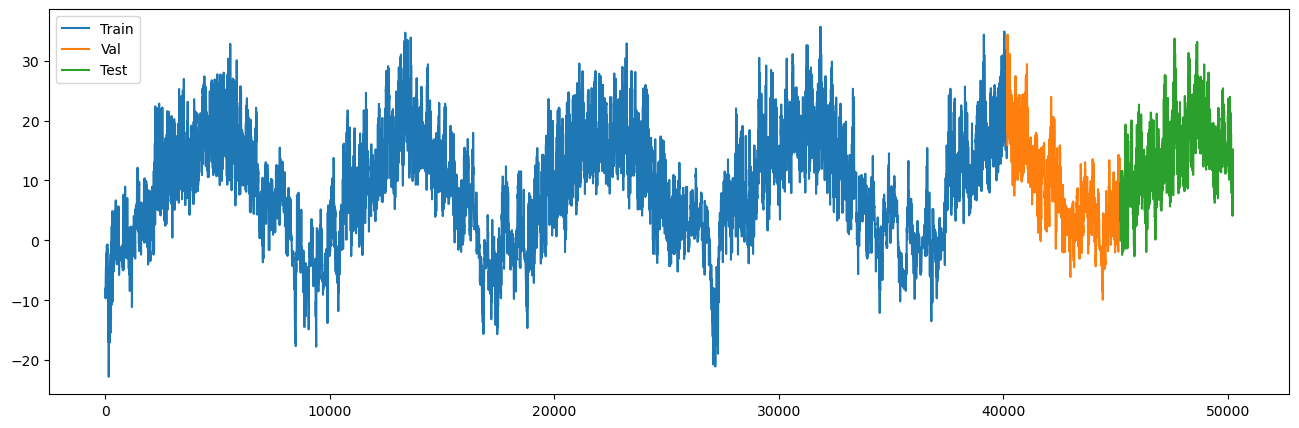

In [5]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

In [6]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red SimpleRNN.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [7]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 4    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (40151, 24, 1), y_tr: (40151, 4, 1)
Set de validación - x_vl: (4994, 24, 1), y_vl: (4994, 4, 1)
Set de prueba - x_ts: (4995, 24, 1), y_ts: (4995, 4, 1)


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))


In [9]:
# Arreglos que contendrán los datasets escalados
x_tr_s = np.zeros(x_tr.shape)
x_vl_s = np.zeros(x_vl.shape)
x_ts_s = np.zeros(x_ts.shape)
y_tr_s = np.zeros(y_tr.shape)
y_vl_s = np.zeros(y_vl.shape)
y_ts_s = np.zeros(y_ts.shape)

x_tr_s[:,:,0] = scaler.fit_transform(x_tr[:,:,0])
x_vl_s[:,:,0] = scaler.transform(x_vl[:,:,0])
x_ts_s[:,:,0] = scaler.transform(x_ts[:,:,0])

# Escalamiento Ys
y_tr_s[:,:,0] = scaler.fit_transform(y_tr[:,:,0])
y_vl_s[:,:,0] = scaler.transform(y_vl[:,:,0])
y_ts_s[:,:,0] = scaler.transform(y_ts[:,:,0])


In [10]:
# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: -22.76/-9.92/-2.64
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.5603492552645094/-0.31107687039890414

Min y_tr/y_vl/y_ts sin escalamiento: -22.76/-9.92/-2.64
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.5603492552645094/-0.31107687039890414

Max x_tr/x_vl/x_ts sin escalamiento: 35.65/34.34/33.68
Max x_tr/x_vl/x_ts con escalamiento: 1.0000000000000002/0.9551446670090742/0.932545796952577

Max y_tr/y_vl/y_ts sin escalamiento: 35.65/31.33/33.68
Max y_tr/y_vl/y_ts con escalamiento: 1.0000000000000002/0.8520801232665642/0.932545796952577


In [11]:
print(tr.values[:29])
print(x_tr[:2,:,:])
print(y_tr[:2,:,:])

[-8.05 -8.88 -8.81 -9.05 -9.63 -9.67 -9.17 -8.1  -7.66 -7.04 -7.41 -6.87
 -5.89 -5.94 -5.69 -5.4  -5.37 -5.25 -5.11 -4.9  -4.8  -4.5  -4.47 -4.54
 -4.44 -4.29 -4.45 -4.58 -4.96]
[[[-8.05]
  [-8.88]
  [-8.81]
  [-9.05]
  [-9.63]
  [-9.67]
  [-9.17]
  [-8.1 ]
  [-7.66]
  [-7.04]
  [-7.41]
  [-6.87]
  [-5.89]
  [-5.94]
  [-5.69]
  [-5.4 ]
  [-5.37]
  [-5.25]
  [-5.11]
  [-4.9 ]
  [-4.8 ]
  [-4.5 ]
  [-4.47]
  [-4.54]]

 [[-8.88]
  [-8.81]
  [-9.05]
  [-9.63]
  [-9.67]
  [-9.17]
  [-8.1 ]
  [-7.66]
  [-7.04]
  [-7.41]
  [-6.87]
  [-5.89]
  [-5.94]
  [-5.69]
  [-5.4 ]
  [-5.37]
  [-5.25]
  [-5.11]
  [-4.9 ]
  [-4.8 ]
  [-4.5 ]
  [-4.47]
  [-4.54]
  [-4.44]]]
[[[-4.44]
  [-4.29]
  [-4.45]
  [-4.58]]

 [[-4.29]
  [-4.45]
  [-4.58]
  [-4.96]]]


In [12]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 1 (feature)

modelo = Sequential()
#modelo.add(SimpleRNN(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
modelo.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 67,076
Trainable params: 67,076
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss=root_mean_squared_error  #loss = 'mse'
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
157/157 - 12s - loss: 0.2369 - val_loss: 0.1130 - 12s/epoch - 79ms/step
Epoch 2/80
157/157 - 7s - loss: 0.1251 - val_loss: 0.1011 - 7s/epoch - 46ms/step
Epoch 3/80
157/157 - 7s - loss: 0.1153 - val_loss: 0.0976 - 7s/epoch - 46ms/step
Epoch 4/80
157/157 - 7s - loss: 0.1085 - val_loss: 0.0941 - 7s/epoch - 46ms/step
Epoch 5/80
157/157 - 7s - loss: 0.1022 - val_loss: 0.0893 - 7s/epoch - 45ms/step
Epoch 6/80
157/157 - 8s - loss: 0.0970 - val_loss: 0.0849 - 8s/epoch - 50ms/step
Epoch 7/80
157/157 - 7s - loss: 0.0928 - val_loss: 0.0822 - 7s/epoch - 47ms/step
Epoch 8/80
157/157 - 7s - loss: 0.0898 - val_loss: 0.0809 - 7s/epoch - 44ms/step
Epoch 9/80
157/157 - 7s - loss: 0.0878 - val_loss: 0.0788 - 7s/epoch - 44ms/step
Epoch 10/80
157/157 - 8s - loss: 0.0860 - val_loss: 0.0794 - 8s/epoch - 49ms/step
Epoch 11/80
157/157 - 7s - loss: 0.0844 - val_loss: 0.0759 - 7s/epoch - 46ms/step
Epoch 12/80
157/157 - 7s - loss: 0.0827 - val_loss: 0.0736 - 7s/epoch - 46ms/step
Epoch 13/80
157/157 - 7

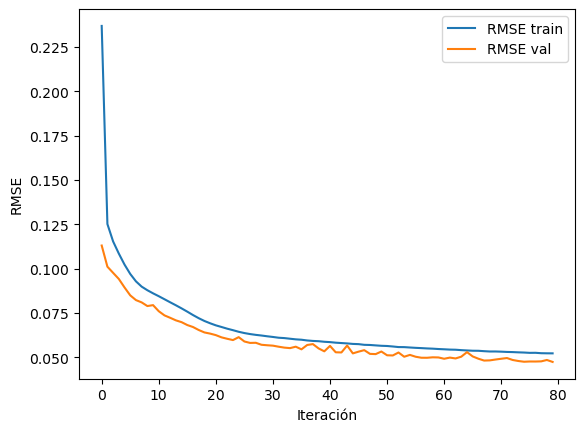

In [14]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

### Desempeño del modelo

In [15]:
# Cálculo de MSE para train, val y test
Rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
Rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
Rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  MSE train:\t {Rmse_tr:.3f}')
print(f'  MSE val:\t {Rmse_vl:.3f}')
print(f'  MSE test:\t {Rmse_ts:.3f}')

Comparativo desempeños:
  MSE train:	 0.048
  MSE val:	 0.046
  MSE test:	 0.052


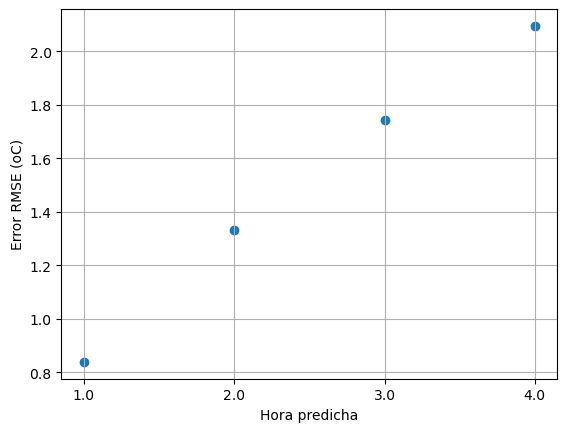

In [16]:
# analizando RMSE en cada una de las 4 predicciones de temperatura
# Calcular predicción sobre el set de prueba escalada en el rango de -1 a 1
y_ts_pred_s = modelo.predict(x_ts_s,verbose=0)

# Llevar la predicción a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred)
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

#Graficar RMSE
t = np.linspace(1,4,4)

fig,ax = plt.subplots()
ax.scatter(t, rmse)
ax.set_xlabel("Hora predicha")
ax.set_ylabel("Error RMSE (oC)")
plt.xticks(ticks=t, labels=t)
plt.grid();




In [17]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [18]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

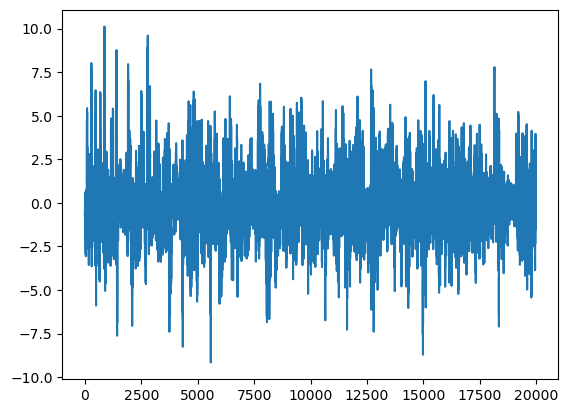

In [19]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);